In [2]:
from re import L
import pandas as pd
import numpy as np
import torch.nn as nn
import torch
import os
from sklearn import preprocessing
import copy

stock_data = pd.read_csv("C:/Users/USER/JupyterProjects/conv_biLSTM_attention_ti/data/kdd17/price_long_50/AAPL.csv" ,header=0,index_col="Date")

open = stock_data.loc[:,"Open"]
high = stock_data.loc[:,"High"]
low = stock_data.loc[:,"Low"]
close = stock_data.loc[:,"Adj Close"]
volume = stock_data.loc[:,"Volume"]

upndown = (stock_data.loc[:, "Adj Close"] - stock_data.loc[:, "Adj Close"].shift(periods=-1, axis=0))
change = (((stock_data.loc[:, "Adj Close"] - stock_data.loc[:, "Adj Close"].shift(periods=-1, axis=0))/stock_data.loc[:, "Adj Close"].shift(periods=-1, axis=0))*100)
tgt = np.where(stock_data.loc[:, "Adj Close"] >= stock_data.loc[:, "Adj Close"].shift(periods=-1, axis=0), 1.0, 0.0)

# technical_indicator

# 1) 10일 이동평균
ten_day_ma = copy.copy(stock_data.loc[:, "Adj Close"])
for i in range(9):
    ten_day_ma += stock_data.loc[:, "Adj Close"].shift(periods = -i-1, axis = 0)

ten_day_ma = ten_day_ma/10 ## 마지막 nan 9개가 생김
    
# 2) 10일 가중 이동평균
w_ten_day_ma = copy.copy(stock_data.loc[:, "Adj Close"])
w_ten_day_ma_10 = copy.copy(w_ten_day_ma*10)
for i in range(9):
    w_ten_day_ma_10 += (9-i)*stock_data.loc[:, "Adj Close"].shift(periods = -i-1, axis = 0)

wma = w_ten_day_ma_10/((10*9)/2)

del w_ten_day_ma
del w_ten_day_ma_10

# 3) momentum
momentum = stock_data.loc[:, "Adj Close"] - stock_data.loc[:, "Adj Close"].shift(periods = -10, axis = 0)


# 4) stochastic_K%
init_low = copy.copy(stock_data.loc[:, "Low"])
init_high = copy.copy(stock_data.loc[:, "High"])

for i in range(9):
    second_low = copy.copy(stock_data.loc[:, "Low"].shift(periods = -i-1, axis = 0))
    second_high = copy.copy(stock_data.loc[:, "High"].shift(periods = -i-1, axis = 0))

    if i == 0:
        lows = pd.concat([init_low,second_low],axis = 1,ignore_index=True)
        highs = pd.concat([init_high,second_high],axis = 1,ignore_index=True)
    else:
        lows = pd.concat([lows,second_low],axis = 1,ignore_index=True)
        highs = pd.concat([highs,second_high],axis = 1,ignore_index=True)

row_low = lows.min(axis=1)
row_high = highs.max(axis=1)

stochastic_K = ((stock_data.loc[:,"Close"]-row_low)/(row_high-row_low))*100

del row_low
del row_high
del lows
del highs
del second_low
del second_high
del init_low
del init_high

# 4) stochastic_D%
stochastic_D = copy.copy(stochastic_K)
for i in range(9):
    stochastic_D += stochastic_K.shift(periods = -i-1, axis = 0)
stochastic_D = stochastic_D/10    

# RSI
difference = stock_data.loc[:, "Adj Close"] - stock_data.loc[:, "Adj Close"].shift(periods = -1, axis = 0)

u = abs(difference.where(difference>0,0))
d = abs(difference.where(difference<0,0))
init_u = copy.copy(u)
init_d = copy.copy(d)

for i in range(9):
    init_u += u.shift(periods = -i-1, axis = 0)
    init_d += d.shift(periods = -i-1, axis = 0)

AU = init_u/10
AD = init_d/10

RSI = 100-100/(1+AU/AD)

del AU
del AD
del init_u
del init_d
del u
del d
del difference

df1 = stock_data.loc[:, "Adj Close"]

df1 = df1.iloc[::-1]


ema_12 = df1.ewm(span=12,min_periods=11,adjust = True).mean()
ema_26 = df1.ewm(span=26,min_periods=25,adjust = True).mean()

# MACD
MACD =  ema_12 - ema_26

MACD = MACD[::-1]

del ema_12
del ema_26
del df1

# Larry_williams_R 
LWR = ((stock_data.loc[:,"High"]-stock_data.loc[:,"Close"])/(stock_data.loc[:,"High"]-stock_data.loc[:,"Low"]))*100

# A_D_Oscillator 
A_D = (stock_data.loc[:,"High"]-stock_data.loc[:,"Close"].shift(periods=-1, axis=0))/(stock_data.loc[:,"High"]-stock_data.loc[:,"Low"])

# CCI
MT = stock_data.loc[:,"High"]+stock_data.loc[:,"Low"]+stock_data.loc[:,"Close"]/3
SMT = copy.copy(MT)
for i in range(9):
    SMT += MT.shift(periods=-1-i, axis=0)

SMT = SMT/10

DT = abs(MT.shift(periods=-9, axis=0) - SMT)
for i in range(9):
    DT += abs(MT.shift(periods=-i, axis=0) - SMT)

DT = DT/10

CCI = (MT -SMT)/(0.015*DT)

del MT
del DT
del SMT

d_len = len(RSI)

df = np.column_stack((open, high, low, close, volume,upndown,change, ten_day_ma,wma, momentum, stochastic_K, stochastic_D,RSI,MACD,LWR))

# scaler  = preprocessing.StandardScaler().fit(df)
# scaled_df = scaler.transform(df)
data = np.column_stack((df,tgt))[:(d_len-24)][::-1].copy()

In [1]:
import torch
import math

pe = torch.zeros((5000, 2)) ## 5000,2
position = torch.arange(0, 5000, dtype=torch.float).unsqueeze(1)
div_term = torch.exp(torch.arange(0, 2, 2).float() * (-math.log(10000.0) / 2))
pe[:, 0::2] = torch.sin(position * div_term)
pe[:, 1::2] = torch.cos(position * div_term)
print(pe.size())
pe = pe.unsqueeze(1)
print(pe.size())

torch.Size([5000, 2])
torch.Size([5000, 1, 2])


In [4]:
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn

tensor1 = torch.zeros(64, 2)
tensor2 = torch.zeros(64, 2)

def metric_acc(y_pred, y_true):
    perc_y_pred = y_pred.detach().cpu().numpy()
    perc_y_true = y_true.detach().cpu().numpy()
    acc = accuracy_score(perc_y_true, perc_y_pred)
    return acc

A = metric_acc(tensor1,tensor2)

print(A)

1.0


In [7]:
for i_th_learning in range(5):
    globals()['acclist_'+str(i_th_learning)] = []

for i in globals():
    if "acclist" in i:
        i.append()
        

        

acclist_0
acclist_1
acclist_2
acclist_3
acclist_4


In [21]:
perc_y_true = [[0., 0., 0., 0., 0.],
               [1., 0., 1., 1., 1.],
               [1., 1., 1., 1., 1.],
               [1., 1., 1., 1., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [1., 1., 1., 1., 1.],
               [1., 1., 1., 1., 1.],
               [0., 0., 0., 0., 0.],
               [0., 1., 1., 0., 1.],
               [1., 1., 1., 1., 1.],
               [0., 0., 0., 0., 0.],
               [0., 0., 1., 0., 1.],
               [0., 1., 1., 1., 1.],
               [0., 1., 1., 0., 0.],
               [1., 0., 1., 1., 1.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 1., 0., 0.],
               [0., 0., 0., 0., 0.],
               [1., 1., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 1., 1., 0.],
               [1., 1., 1., 1., 1.],
               [0., 0., 1., 0., 1.],
               [1., 1., 1., 1., 1.],
               [1., 1., 1., 1., 0.],
               [1., 0., 1., 1., 1.],
               [1., 1., 0., 1., 1.],
               [0., 0., 0., 0., 0.],
               [0., 1., 0., 1., 0.],
               [1., 0., 0., 0., 0.],
               [1., 1., 1., 1., 1.],
               [0., 0., 0., 0., 0.],
               [0., 0., 1., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 1., 1., 1., 0.],
               [1., 1., 1., 0., 1.],
               [1., 0., 0., 0., 0.],
               [1., 1., 1., 1., 1.],
               [1., 0., 1., 1., 1.],
               [1., 1., 1., 1., 1.],
               [1., 0., 0., 1., 1.],
               [1., 0., 1., 0., 0.],
               [0., 0., 0., 0., 0.],
               [1., 0., 1., 1., 1.],
               [0., 0., 0., 1., 1.],
               [1., 1., 1., 1., 1.],
               [1., 0., 1., 1., 1.],
               [1., 1., 0., 1., 0.],
               [1., 1., 1., 0., 0.],
               [0., 0., 1., 1., 1.],
               [1., 1., 1., 1., 1.],
               [0., 0., 0., 1., 1.],
               [0., 0., 1., 0., 1.],
               [0., 1., 0., 0., 0.],
               [1., 1., 1., 0., 1.],
               [1., 1., 0., 1., 1.],
               [0., 1., 1., 1., 1.],
               [0., 0., 0., 1., 0.],
               [1., 0., 0., 1., 1.],
               [0., 1., 0., 1., 0.],
               [1., 1., 1., 1., 1.],
               [0., 1., 0., 0., 1.]]

perc_y_pred = [[1., 0., 0., 0., 1.],
               [1., 0., 0., 0., 1.],
               [1., 0., 1., 0., 0.],
               [1., 0., 1., 0., 0.],
               [1., 0., 0., 1., 0.],
               [1., 0., 0., 1., 1.],
               [1., 0., 1., 0., 0.],
               [1., 0., 1., 0., 0.],
               [1., 0., 1., 1., 1.],
               [1., 0., 0., 1., 1.],
               [1., 0., 1., 1., 0.],
               [1., 0., 1., 1., 1.],
               [1., 0., 1., 0., 0.],
               [0., 0., 1., 0., 0.],
               [0., 0., 1., 0., 0.],
               [0., 0., 1., 1., 0.],
               [0., 0., 1., 1., 0.],
               [0., 0., 1., 1., 0.],
               [0., 0., 1., 1., 0.],
               [0., 0., 1., 1., 0.],
               [1., 0., 1., 1., 0.],
               [1., 0., 1., 0., 0.],
               [1., 0., 1., 0., 0.],
               [1., 0., 1., 0., 0.],
               [1., 0., 1., 0., 0.],
               [1., 0., 1., 0., 0.],
               [1., 0., 1., 0., 1.],
               [1., 0., 0., 0., 1.],
               [1., 0., 0., 1., 1.],
               [1., 0., 0., 1., 1.],
               [1., 0., 0., 1., 1.],
               [1., 0., 0., 1., 1.],
               [1., 1., 0., 1., 1.],
               [1., 0., 0., 1., 1.],
               [1., 0., 0., 1., 1.],
               [1., 0., 0., 1., 1.],
               [1., 0., 1., 1., 0.],
               [1., 0., 1., 0., 0.],
               [1., 0., 1., 0., 0.],
               [1., 0., 1., 0., 0.],
               [0., 0., 1., 0., 0.],
               [1., 0., 1., 1., 0.],
               [1., 0., 1., 1., 0.],
               [1., 0., 0., 1., 1.],
               [1., 0., 0., 1., 1.],
               [1., 0., 0., 1., 1.],
               [1., 0., 0., 1., 1.],
               [1., 0., 0., 1., 1.],
               [1., 0., 0., 1., 1.],
               [1., 0., 0., 1., 1.],
               [1., 1., 0., 0., 1.],
               [1., 1., 0., 0., 1.],
               [1., 1., 0., 0., 1.],
               [1., 1., 0., 0., 1.],
               [1., 1., 0., 1., 1.],
               [1., 1., 0., 1., 1.],
               [1., 1., 0., 1., 1.],
               [1., 1., 0., 1., 1.],
               [1., 0., 0., 1., 0.],
               [1., 0., 1., 1., 0.],
               [1., 1., 0., 1., 0.],
               [1., 1., 0., 1., 0.],
               [1., 1., 0., 0., 0.],
               [1., 1., 0., 0., 1.]]

perc_y_true
a = np.array(perc_y_pred)
b = np.array(perc_y_true)
print(a[:,0])
print(b[:,0])
acc = accuracy_score(a[:,0],b[:,0])
print(acc)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1.
 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0.]
0.5625


In [17]:
perc_y_true = np.array([[0., 0., 0., 0., 0.],[1., 0., 1., 1., 1.]])
               

perc_y_pred = np.array([[1., 0., 0., 0., 1.],[1., 0., 0., 0., 1.]])


acc = accuracy_score(np.array([[0., 0., 0., 0., 0.],[1., 0., 1., 1., 1.]]),np.array([[1., 0., 0., 0., 1.],[1., 0., 0., 0., 1.]]))*100
print(acc)

0.0


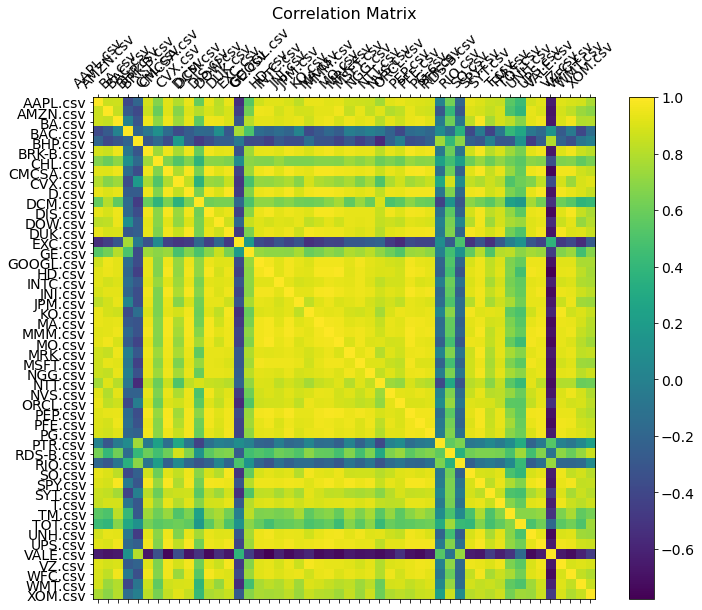

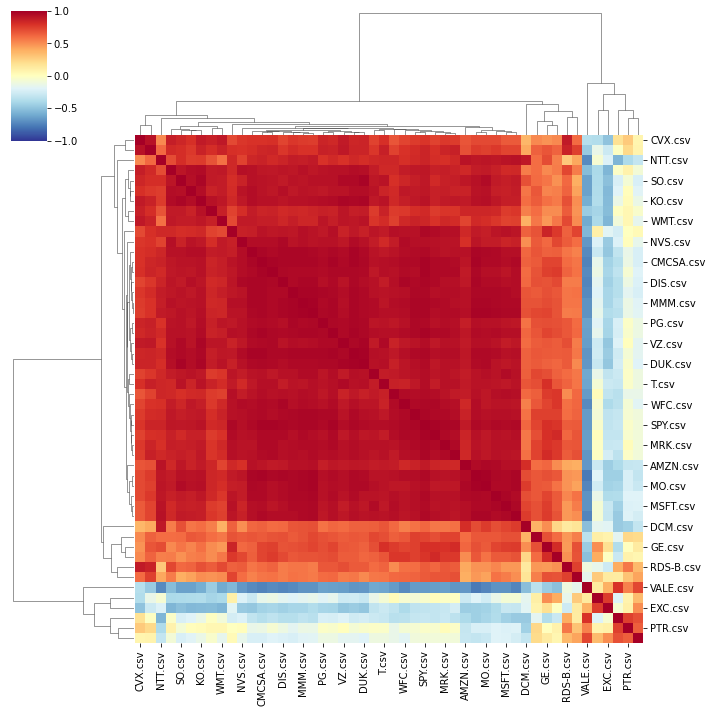

In [54]:

import matplotlib.pyplot as plt
import seaborn as sns


# stock_data = pd.read_csv("C:/Users/USER/JupyterProjects/conv_biLSTM_attention_ti/data/kdd17/price_long_50/AAPL.csv" ,header=0,index_col="Date")

# plt.matshow(dataframe.corr())
# plt.show()


# f = plt.figure(figsize=(19, 15))
# plt.matshow(df.corr(), fignum=f.number)
# plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
# plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=14)
# plt.title('Correlation Matrix', fontsize=16);



import pandas as pd
import numpy as np
data_list = os.listdir("C:/Users/USER/JupyterProjects/bilstm_attention_ti_cor/data/kdd17/price_long_50/")

data_list1 = data_list.split(".")

stock_list = pd.DataFrame([])
for i ,data in enumerate(data_list):
    stock_data = pd.read_csv("C:/Users/USER/JupyterProjects/bilstm_attention_ti_cor/data/kdd17/price_long_50/"+ data ,header=0)
    close = stock_data.loc[:,"Adj Close"]
    stock_list = pd.concat([stock_list,close],axis =1)

stock_list.columns = data_list
    
f = plt.figure(figsize=(12, 9))
plt.matshow(stock_list.corr(), fignum=f.number)
plt.xticks(range(stock_list.shape[1]), stock_list.columns, fontsize=14, rotation=45)
plt.yticks(range(stock_list.shape[1]), stock_list.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

stock_list = stock_list.corr()

sns.clustermap(stock_list,    # 실제 값 화면에 나타내기
               cmap = 'RdYlBu_r',  # Red, Yellow, Blue 색상으로 표시
               vmin = -1, vmax = 1, #컬러차트 -1 ~ 1 범위로 표시
              )